# Fitting

In [52]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [53]:
def load_data(filename, L, n):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    data = marginalize_counts(data, 4)

    targets = counts_to_probs(data)
    targets_spam = targets[:6**n]
    targets_map = targets[6**n:]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    circuit_target = pqc_basic(n, L)
    unitary = Operator(circuit_target).data

    inputs_spam, _ = generate_pauliInput_circuits(n)
        
    inputs_map, circuit_list_map = (
                generate_pauli_circuits(n, None, N=5000-6**n)
        )
    
    return inputs_spam, targets_spam, inputs_map, targets_map, unitary

def fit_spam(inputs, 
             targets,
             num_iter = 2000):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = False,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets, 
              spam_model,
              num_iter = 2000,
              verbose = False):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue()], sample_freq=100),
                )

    model.train(inputs = inputs,
                targets = targets,
                inputs_val = [inputs],
                targets_val = [targets],
                num_iter = num_iter,
                N = 500,
                verbose=verbose
                )
    
    return model

## L = 8

In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=8.pkl', L=8, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000,
                  verbose=True)

model_saver(model, "models/L=8.model")

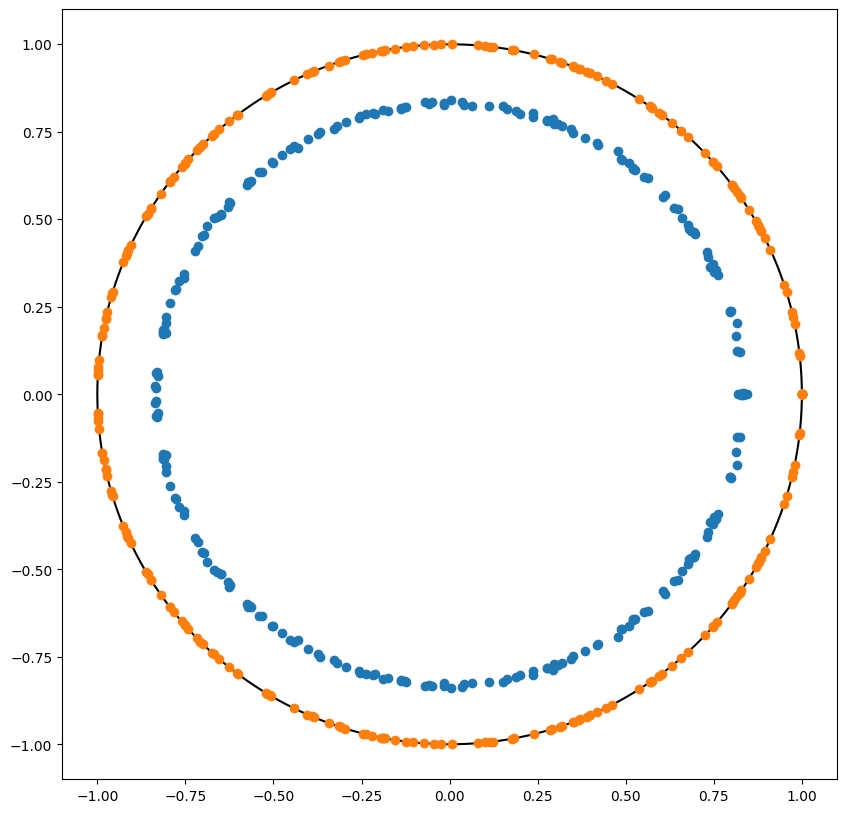

In [50]:
spectrum_target = channel_spectrum(channel_target)
spectrum = channel_spectrum(model.channel)

spectrum.plot_circle()
spectrum.plot()
spectrum_target.plot()
plt.show()

## L = 16

In [51]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=16.pkl', L=16, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=16.model")

KeyboardInterrupt: 

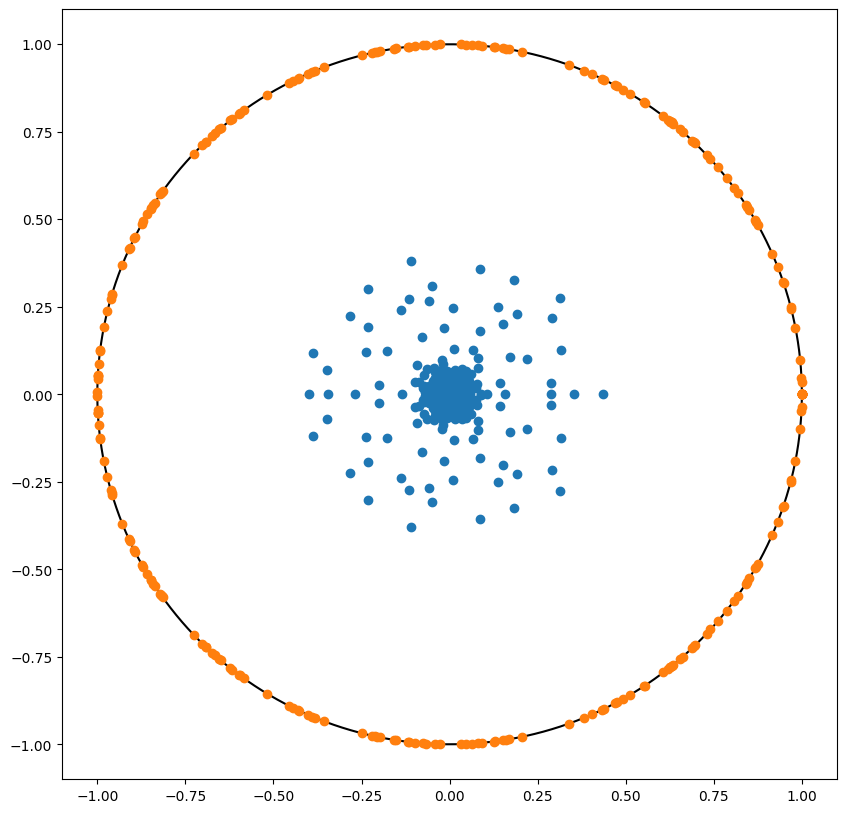

In [ ]:
spectrum_target = channel_spectrum(channel_target)
spectrum = channel_spectrum(model.channel)

spectrum.plot_circle()
spectrum.plot()
spectrum_target.plot()
plt.show()

## L = 24

In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=24.pkl', L=24, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                  num_iter = 2000)
model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=24.model")

[0.9081642466258765]


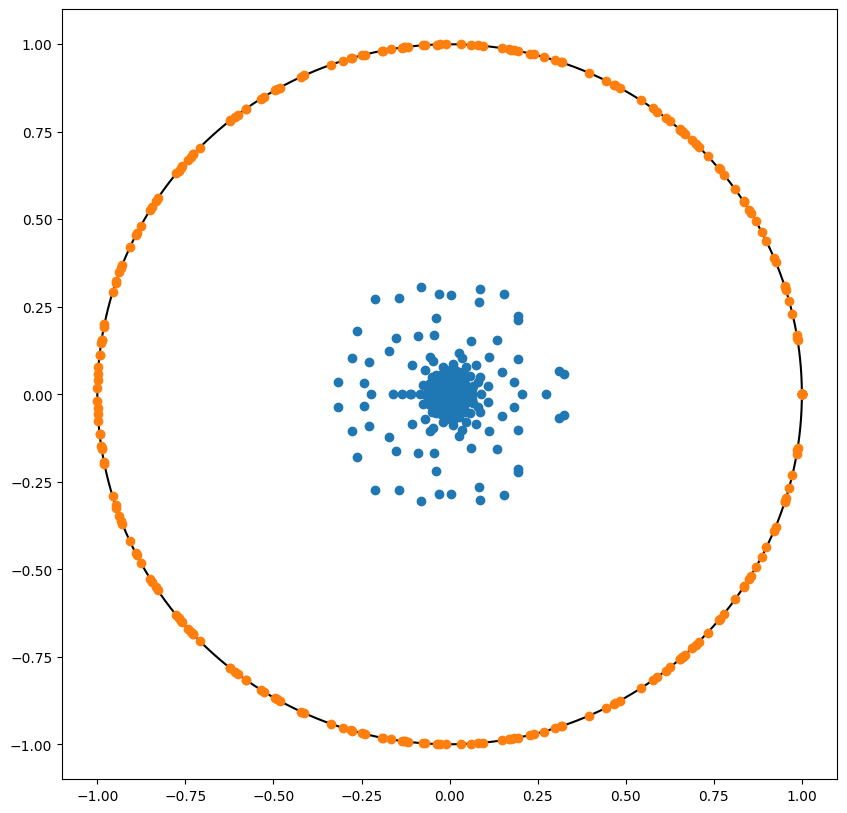

In [ ]:
spectrum_target = channel_spectrum(channel_target)
spectrum = channel_spectrum(model.channel)

spectrum.plot_circle()
spectrum.plot()
spectrum_target.plot()
plt.show()

## L = 32

In [22]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=32.pkl', L=32, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)
model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=32.model")

[0.9147759091272964]


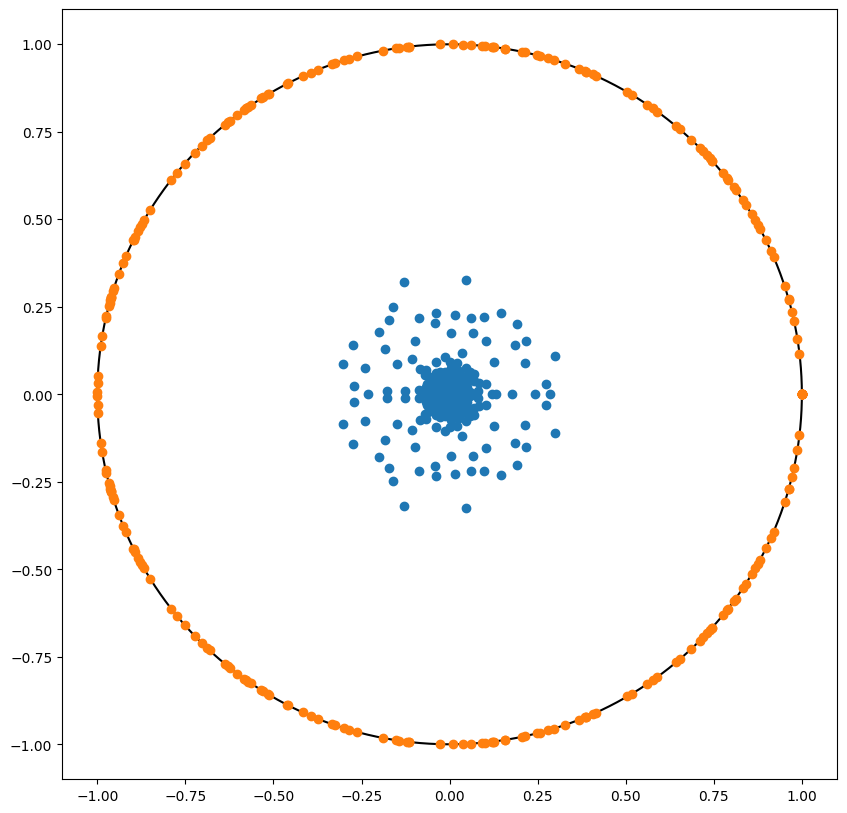

In [ ]:
spectrum_target = channel_spectrum(channel_target)
spectrum = channel_spectrum(model.channel)

spectrum.plot_circle()
spectrum.plot()
spectrum_target.plot()
plt.show()

## L = 40

In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=40.pkl', L=40, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam, 
                      num_iter = 2000)
model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=40.model")

[0.932543290960871]


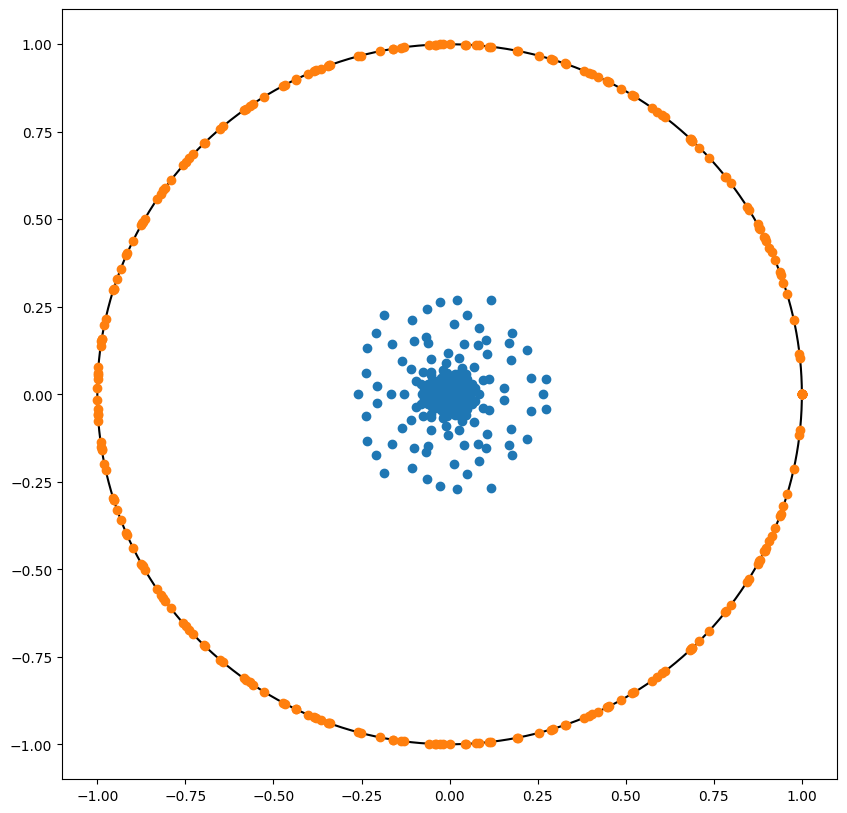

In [ ]:
spectrum_target = channel_spectrum(channel_target)
spectrum = channel_spectrum(model.channel)

spectrum.plot_circle()
spectrum.plot()
spectrum_target.plot()
plt.show()

# L = 56

In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=56.pkl', L=56, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=56.model")

[0.9506439080814152]


In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=72.pkl', L=72, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=72.model")

[0.9739771109379995]


In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=88.pkl', L=88, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=88.model")

KeyboardInterrupt: 

In [ ]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=104.pkl', L=104, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=104.model")

ValueError: in user code:

    File "c:\Users\krist\Documents\ModelNISQ2\notebooks\integrability\zheijang\pqc_twirl\../../../../src_tf\optimization.py", line 242, in train_step  *
        loss = self.loss(inputs_batch, targets_batch)
    File "c:\Users\krist\Documents\ModelNISQ2\notebooks\integrability\zheijang\pqc_twirl\../../../../src_tf\optimization.py", line 231, in loss  *
        outputs_batch = measurement(
    File "c:\Users\krist\Documents\ModelNISQ2\notebooks\integrability\zheijang\pqc_twirl\../../../../src_tf\quantum_tools.py", line 228, in measurement  *
        state = apply_unitary(state, U_basis)
    File "c:\Users\krist\Documents\ModelNISQ2\notebooks\integrability\zheijang\pqc_twirl\../../../../src_tf\quantum_tools.py", line 172, in apply_unitary  *
        Ustate = tf.matmul(U, state)

    ValueError: Dimensions must be equal, but are 16 and 32 for '{{node MatMul_1}} = BatchMatMulV2[T=DT_COMPLEX128, adj_x=false, adj_y=false, grad_x=false, grad_y=false](inputs_batch, Repeat/Reshape_1)' with input shapes: [1296,16,16], [1296,32,32].


In [10]:
inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data('data/L=120.pkl', L=120, n=4)
channel_target = ChoiMapStatic(unitary, mode = "unitary")

spam_model = fit_spam(inputs_spam, 
                      targets_spam,
                      num_iter = 2000)

model = fit_model(inputs_map, 
                  targets_map, 
                  spam_model,
                  num_iter = 2000)

model_saver(model, "models/L=120.model")

[0.6730780262906676]
